In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange

In [5]:
class Sharp_grad_X:
    def __init__(self,num_neuron, t_initial,t_final,k):
        self.num_neuron = num_neuron
        self.t0 = t_initial
        self.tfi = t_final
        self.k = k
    
        self.calculate_and_plot()
    
    def tune_hyper_parameters(self):
        '''
        Given the target number of neurons(num_neuron), the function we determine:
        * number of training point in the interval t_initial and t_final
        * the alpha and beta in the interval S_shape


        NB :make sure that the length of the interval is 1.
        '''
    

        num_trial_points = int(self.num_neuron/0.23)+1   #found imperically, tweak it as you please
        M = num_trial_points//2

        self.x = tf.cast(tf.linspace(self.t0,self.tfi,M)[:,None], tf.float32)

        value = int((num_trial_points - 10)/10) + 4
        # value = 10.

        uniform_int_alpha = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=1)
        uniform_int_beta = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=2)


        alpha = uniform_int_alpha(shape=(num_trial_points,))
        beta = uniform_int_beta(shape=(num_trial_points,))

        C = -beta/alpha


        good_alpha = []
        good_beta = []
        C_good = []
        counter = 0

        for i in tnrange(len(alpha)):
            value = (2.945)/alpha[i]
            low = C[i] - value
            high = C[i] + value

            if C[i] > self.x[0]  and C[i] <self.x[-1]:
                counter +=1
                good_alpha.append(alpha[i])
                good_beta.append(beta[i])
                C_good.append(C[i]) 

        return counter,good_alpha, good_beta      
        
    @staticmethod
    def sigma(x,alpha,beta):
        return 1./(1.+ tf.math.exp(-alpha*x -beta ))
    
    @staticmethod
    def S_matrices(x_m_minus_2,alpha,beta):
        with tf.autodiff.ForwardAccumulator(primals=x_m_minus_2,tangents=tf.ones_like(x_m_minus_2)) as outer:
            with tf.autodiff.ForwardAccumulator(primals=x_m_minus_2,tangents=tf.ones_like(x_m_minus_2)) as inner:
                S0 = Sharp_grad_X.sigma(x_m_minus_2,alpha,beta )
            S1 = inner.jvp(S0)
        S2 = outer.jvp(S1)  
        return S0,S1,S2

    @staticmethod
    def B_matrices(init_array,alpha,beta):
    #     xk = tf.constant(init_array,dtype=tf.float32)
        xk = init_array
        with tf.autodiff.ForwardAccumulator(primals=xk,tangents=tf.ones_like(xk)) as tape:
            B0 = Sharp_grad_X.sigma(xk,alpha,beta )
        B1 = tape.jvp(B0)
        return B0,B1
    
    def calculate_and_plot(self):
        neurons,good_alpha, good_beta   = self.tune_hyper_parameters()
        print(f'neurons :{neurons}')
        M = neurons//2
        alpha = tf.convert_to_tensor(good_alpha,tf.float32)
        beta = tf.convert_to_tensor(good_beta,tf.float32)

        x_m_minus_2 = tf.linspace(self.x[1],self.x[-2],M-2)
        k = self.k
        S0,S1,S2 = self.S_matrices(x_m_minus_2,alpha,beta)
        int_array = tf.concat([self.x[0],self.x[-1]],axis=0)[:,None]
        B0,B1 = Sharp_grad_X.B_matrices(int_array,alpha,beta)

        fg = np.zeros((M,1))
        SB_matrix = np.zeros((M,neurons))
        lhs_eqn = S2 + (4.*tf.pow(k*np.pi,2) - 1.)*S0
        rhs_eqn = 4.*k*np.pi*tf.math.exp(x_m_minus_2)*tf.math.cos(2.*k*np.pi*x_m_minus_2)

        lhs_BC =  B0
        rhs_BC =  tf.zeros((2,1))
        # 

        # First row == B0[0]
        SB_matrix[0] = lhs_BC[0]
        # Last row == B0[-1]
        SB_matrix[-1] = lhs_BC[-1]
        # inbetween == rhs_eqn
        SB_matrix[1:-1] = lhs_eqn

        # FG matrix
        # First row == B0[0]
        fg[0] = rhs_BC[0]
        # Last row == B0[-1]
        fg[-1] = rhs_BC[-1]
        # inbetween == rhs_eqn
        fg[1:-1] = rhs_eqn

        weight = tf.linalg.pinv(SB_matrix)@fg
        weight = tf.cast(weight, tf.float32)
        u_hat = Sharp_grad_X.sigma(self.x, alpha, beta)@weight
        u = lambda x: tf.math.exp(x)*tf.math.sin(2.*k*np.pi*x)
        error = tf.norm(u_hat- u(self.x))
        mse = tf.reduce_mean(tf.square(u_hat- u(self.x)))
        residue = SB_matrix@weight - fg
        res_nrom = tf.norm(residue)
        res_mse = tf.reduce_mean(tf.square(residue))
        print(f'Residue Norm  : {res_nrom}')
        print(f'Residue mse  : {res_mse}')
        print(f'Error : {tf.norm(error)}') 
        print(f'mse Error  : {mse}')
        plt.plot(self.x,u(self.x))
        plt.plot(self.x,u_hat, 'r--')
        # plt.xlim(0.4)
        # plt.ylim(-50.,50.)
        plt.show()              


  0%|          | 0/653 [00:00<?, ?it/s]

neurons :150
Residue Norm  : 0.010112816467881203
Residue mse  : 1.3635874438477913e-06
Error : 0.25630515813827515
mse Error  : 0.00020151023636572063


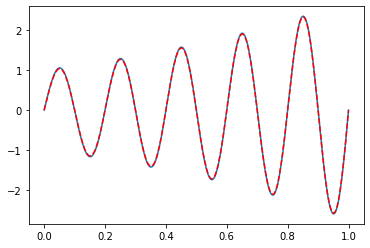

In [6]:
num_neuron, t_initial,t_final,k = 150, 0.,1.,5
test = Sharp_grad_X(num_neuron, t_initial,t_final,k)

  0%|          | 0/783 [00:00<?, ?it/s]

neurons :186
Residue Norm  : nan
Residue mse  : nan
Error : nan
mse Error  : nan


2023-02-08 01:05:40.311648: E ./tensorflow/core/kernels/linalg/svd_op_impl.h:110] Eigen::BDCSVD failed with error code 3


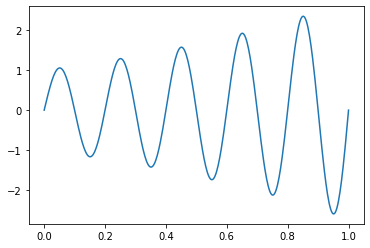

In [23]:
# k = 1
num_neuron, t_initial,t_final,k = 180, 0.,1.,5
test = Sharp_grad_X(num_neuron, t_initial,t_final,k)